In [1]:
# ANNOTATION PROBLEMS
import pathlib
import json
import tqdm
import pandas as pd

disambig = set(pd.read_csv("../data/wikidata-20211122-disambig.txt", header=None)[0])
listpage = set(pd.read_csv("../data/wikidata-20211122-list.txt", header=None)[0])

ROOT = pathlib.Path("Mewsli-9+badent")

badcounts = {}
for file in tqdm.tqdm(list(ROOT.glob("*.tsv"))):
    lang = file.stem
    try:
        refs = [
            ref
            for _, links, text in (l.split("\t") for l in file.open())
            for surface, ref in json.loads(links).items()
        ]
    except Exception as e:
        for i, (_, links, text) in enumerate(l.split("\t") for l in file.open()):
            try:
                json.loads(links)
            except Exception as e:
                print(file, i, links)
        raise e

    badcounts[lang] = {
        "disambig": sum(1 for r in refs if r in disambig),
        "listpage": sum(1 for r in refs if r in listpage),
        "total": len(refs),
    }
pd.DataFrame(badcounts)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


,en,ar,de,es,fa,ja,sr,ta,tr,nl
disambig,2751,201,1907,1923,5,605,773,28,164,562
listpage,259,4,76,105,0,54,7,1,5,16
total,79258,5964,64807,55431,515,34214,35536,2683,5661,11924


In [2]:
pd.DataFrame(badcounts).T.sort_values("total")[::-1].T

,en,de,es,sr,ja,nl,ar,tr,ta,fa
disambig,2751,1907,1923,773,605,562,201,164,28,5
listpage,259,76,105,7,54,16,4,5,1,0
total,79258,64807,55431,35536,34214,11924,5964,5661,2683,515


In [3]:
import pathlib
import glob
import json

import dawg
import tqdm
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

ROOT = pathlib.Path("Mewsli-9")

results = {}
for file in tqdm.tqdm(list(ROOT.glob("*.tsv"))):
    lang = file.stem
    index = glob.glob(f"../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg")[0]
    wm = dawg.IntDAWG().load(index)

    cache = {}

    def predict(sent, surface, wm):
        ref = cache.setdefault(surface, wm.get(surface.replace(" ", "_")))
        return ref or -1

    surface, pred, gold = zip(
        *[
            (surface, predict(text, surface, wm), ref)
            for _, links, text in (l.split("\t") for l in file.open())
            for surface, ref in json.loads(links).items()
        ]
    )

    res = (
        pd.DataFrame(
            {
                avg: precision_recall_fscore_support(
                    gold, pred, zero_division=0, average=avg
                )[:-1]
                for avg in ["micro", "macro"]
            },
            index=["precision", "recall", "fscore"],
        )
        .unstack()
        .T
    )
    res.loc[("", "support")] = len(gold)
    results[lang] = res

(
    pd.DataFrame(results)
    .T.sort_values(("", "support"))[::-1]
    .style.bar(vmin=0, vmax=1, color="lightblue")
    .format("{:.2f}")
    .set_caption("Wikipedia Page Name Baseline")
)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


# Rank analysis

In [4]:
import json, re, html, pathlib
from collections import Counter

import matplotlib.pyplot as plt

from minimel.normalize import normalize, SNOWBALL_LANG

code_lang = dict(SNOWBALL_LANG)
code_lang["fa"] = "Persian"
code_lang["ja"] = "Japanese"


def rank(wm, counts, surface, i, stem=None):
    for norm in normalize(surface, language=stem):
        norm = norm.lower()
        ent_count = counts.get(norm, {})
        if len(ent_count) == 1 and ent_count.get("Q%s" % i):
            return ent_count["Q%s" % i], -1
        if ent_count.get("Q%s" % i):
            order = sorted(ent_count, key=lambda x: -ent_count[x])
            return ent_count["Q%s" % i], order.index("Q%s" % i)
    if wm.get(surface.replace(" ", "_")) == i:
        return 1, -1
    return 0, None


total_counts = {}
ranks = {}
stem_ranks = {}
for file in tqdm.tqdm(list(ROOT.glob("*.tsv"))):
    lang = file.stem
    # if lang not in ['ta','nl', 'tr']:
    #     continue
    index = glob.glob(f"../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg")[0]
    wm = dawg.IntDAWG().load(index)

    counttypes = []

    countfile = pathlib.Path(index).parent / "count.min2.json"
    if not countfile.exists():
        continue
    counts = json.load(open(countfile))
    counttypes += [(counts, None, ranks)]

    stemfile = pathlib.Path(index).parent / f"count.min2.stem-{lang}.json"
    if not stemfile.exists():
        stemfile = pathlib.Path(index).parent / f"count.min2-stem.json"
        if not stemfile.exists():
            continue
    counttypes += [(json.load(open(stemfile)), lang, stem_ranks)]

    total_counts[lang] = Counter()
    for ec in counts.values():
        for e, c in ec.items():
            total_counts[lang][int(e.replace("Q", ""))] += c

    for c, stem, r in counttypes:
        r[lang] = pd.DataFrame(
            [
                (surface, ref, *rank(wm, c, surface, ref, stem=stem))
                for _, links, text in (l.split("\t") for l in file.open())
                for surface, ref in json.loads(links).items()
                if ref not in disambig
            ],
            columns=["surface", "ref", "count", "rank"],
        )
len(ranks), len(stem_ranks)

100%|████████████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.08s/it]


(9, 9)

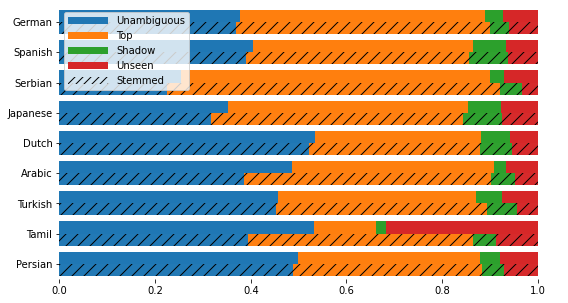

In [10]:
from matplotlib.legend_handler import HandlerTuple


def cat(x):
    return (
        "Unseen"
        if pd.isna(x)
        else ("Shadow" if x > 0 else (" Top" if x == 0 else "  Unambiguous"))
    )


fig, ax = plt.subplots(figsize=(9, 5))
pd.DataFrame(
    {
        code_lang.get(l, l).title(): r["rank"].apply(cat).value_counts() / len(r)
        for l, r in sorted(ranks.items(), key=lambda x: -len(x[1]))[::-1]
    }
).sort_index().T.plot.barh(ax=ax, stacked=True, width=0.4, position=0)
x = (
    pd.DataFrame(
        {
            code_lang.get(l, l).title(): r["rank"].apply(cat).value_counts() / len(r)
            for l, r in sorted(stem_ranks.items(), key=lambda x: -len(x[1]))[::-1]
        }
    )
    .sort_index()
    .T.plot.barh(ax=ax, stacked=True, width=0.4, position=1, hatch="//", alpha=0.99)
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
import matplotlib.patches as mpatches

hatch = mpatches.Patch(facecolor="None", hatch=r"///", alpha=0.99, label="Stemmed")

ax.set_ylim([-0.5, len(ranks) - 0.5])
ax.legend(
    handles[:4] + [hatch],
    [l.strip() for l in labels[:4]] + ["Stemmed"],
    loc="upper left",
    handlelength=4,
    # handler_map={tuple: HandlerTuple(ndivide=None)}
)

plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.savefig(f"../paper/fig/shadow.pgf", bbox_inches="tight")
plt.savefig(f"../paper/fig/shadow.pdf", bbox_inches="tight")

<AxesSubplot:>

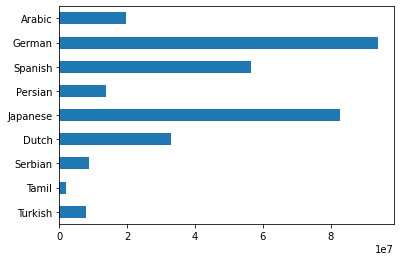

In [6]:
pd.Series(
    {
        code_lang.get(l, l).title(): sum(c.values())
        for l, c in sorted(total_counts.items())[::-1]
    }
).plot.barh()

# Filtering Analysis

In [7]:
lang_cleancurves = {}
for file in tqdm.tqdm(list(ROOT.glob("*.tsv"))):
    lang = file.stem
    cleans = glob.glob(f"../wiki/{lang}wiki-*/count.min2.clean*.json")
    if cleans:
        clean = sorted(
            [pathlib.Path(f) for f in cleans], key=lambda x: -x.stat().st_size
        )[0]
        surface_weight = json.load(open(clean))
        clean_pairs_score = set(
            (-v, s, int(k.replace("Q", "")))
            for s, kv in surface_weight.items()
            for i, (k, v) in enumerate(kv.items())
            if i > 0
        )
        test_pairs = set(
            (norm, int(ref))
            for surface, ref in ranks[lang][ranks[lang]["rank"] > 0][
                ["surface", "ref"]
            ].values
            for norm in normalize(surface)
        )
        clean_in_test = [(s, r) in test_pairs for _, s, r in sorted(clean_pairs_score)]
        tp = pd.Series(clean_in_test).cumsum()
        precision = tp / (tp.index + 1)
        recall = tp / len(test_pairs)
        lang_cleancurves[lang] = (precision, recall)

100%|████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.36s/it]


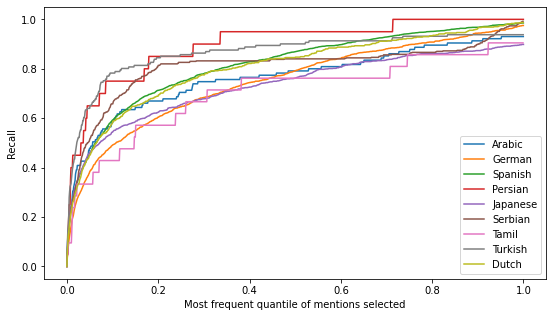

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))
for lang, (pr, re) in lang_cleancurves.items():
    n = int(len(pr) / 1000)
    langname = code_lang[lang].title()
    plt.plot(
        re.index[re.index % n == 0] / len(re), re[re.index % n == 0], label=langname
    )
plt.legend()
ax.set(xlabel="Most frequent quantile of mentions selected", ylabel="Recall")

plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.savefig(f"../paper/fig/quantile-filter.pgf", bbox_inches="tight")

In [102]:
lang_cleancurves = {}
for file in tqdm.tqdm(list(ROOT.glob("*.tsv"))):
    lang = file.stem
    cleans = glob.glob(f"../wiki/{lang}wiki-*/count.min2.clean*.json")
    if cleans:
        clean = sorted(
            [pathlib.Path(f) for f in cleans], key=lambda x: -x.stat().st_size
        )[0]
        surface_weight = json.load(open(clean))

        test_pairs = set(
            (norm, int(ref))
            for surface, ref in ranks[lang][ranks[lang]["rank"] > 0][
                ["surface", "ref"]
            ].values
            for norm in normalize(surface)
        )

        print(lang, len(surface_weight), len(test_pairs))

        surface_top = {
            s: sorted(kv.items(), key=lambda x: -x[1])[0]
            for s, kv in surface_weight.items()
        }
        count_pairs = sorted(
            (
                (c, n, e)
                for n, kv in surface_weight.items()
                if len(kv) > 1
                for e, c in list(kv.items())[1:]
            )
        )[::-1]

        for frac in [0.25, 0.5, 1]:
            limit = int(len(count_pairs) * frac)
            new_surface_weight = {}
            for c, n, e in count_pairs[:limit]:
                new_surface_weight.setdefault(n, dict([surface_top[n]]))[e] = c
            print(
                lang,
                frac,
                len(new_surface_weight),
                sum(
                    1
                    for n, e in test_pairs
                    if new_surface_weight.get(n, {}).get(str(e))
                )
                / len(test_pairs),
            )
            with open(
                f"../wiki/{lang}wiki-20220301/experiments/clean-q{frac}.json", "w"
            ) as fw:
                json.dump(new_surface_weight, fw)

  0%|                                                                                                                                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]

ar 1003805 117
ar 0.25 19733 0.7350427350427351
ar 0.5 36057 0.8461538461538461
ar 1 68090 0.9914529914529915


 20%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                 | 2/10 [00:05<00:20,  2.50s/it]

de 3111050 1755
de 0.25 74209 0.6524216524216524
de 0.5 136793 0.8005698005698005
de 1 244401 0.9829059829059829


 30%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 3/10 [00:20<00:56,  8.01s/it]

es 1853825 2289
es 0.25 45186 0.7518567059851463
es 0.5 80662 0.8680646570554827
es 1 148661 0.9925731760594146


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 4/10 [00:31<00:54,  9.05s/it]

fa 635191 20
fa 0.25 12389 0.85
fa 0.5 21369 0.95
fa 1 40784 1.0


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 5/10 [00:35<00:35,  7.14s/it]

ja 1770910 1280
ja 0.25 33959 0.6734375
ja 0.5 62368 0.79765625
ja 1 116013 0.92890625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 6/10 [00:43<00:30,  7.62s/it]

sr 441021 501
sr 0.25 20154 0.8303393213572854
sr 0.5 29876 0.8622754491017964
sr 1 50850 0.998003992015968


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 7/10 [00:46<00:18,  6.19s/it]

ta 113272 21


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 8/10 [00:47<00:08,  4.42s/it]

ta 0.25 1833 0.6666666666666666
ta 0.5 3434 0.8095238095238095
ta 1 6584 0.9523809523809523
tr 381905 162
tr 0.25 6986 0.8950617283950617
tr 0.5 12826 0.9444444444444444


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 9/10 [00:48<00:03,  3.49s/it]

tr 1 23326 0.9876543209876543
nl 1293079 544
nl 0.25 30472 0.7426470588235294
nl 0.5 56249 0.8455882352941176
nl 1 100134 0.9926470588235294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.48s/it]


In [23]:
lang = "nl"
r = ranks[lang]

In [31]:
# Unseen
r[r["count"] == 0].fillna(-1).value_counts().rename("test_count").reset_index().head(20)

KeyError: 'count'

In [14]:
# Shadow
r[r["rank"] > 0].fillna(-1).value_counts().rename("test_count").reset_index().head(20)

,surface,ref,count,rank,0
0,May,264766,15,2.0,6
1,Openbaar Ministerie,11775750,312,1.0,6
2,Washington,61,1112,1.0,5
3,ESM,1130098,30,1.0,5
4,China,148,6406,1.0,5
5,Peter Madsen,2076849,10,1.0,5
6,Amerikaanse presidentsverkiezingen,699872,17,2.0,5
7,NPS,2564279,201,1.0,4
8,Groningen,752,6298,1.0,4
9,burgeroorlog,19686631,7,15.0,4


<AxesSubplot:>

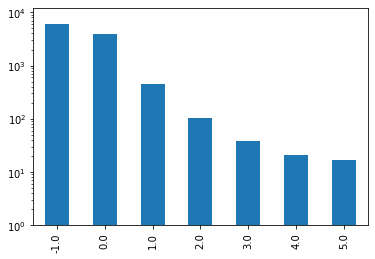

In [15]:
r["rank"].value_counts().head(7).plot.bar(
    logy=True, ylim=[1, r["rank"].value_counts().max() * 2]
)

In [16]:
len(total_counts["nl"])

1146616

In [17]:
count = json.load(open("../wiki/nlwiki-20220301/count.min2.json"))

In [18]:
clean = json.load(open("../wiki/nlwiki-20220301/count.min2.clean8549.json"))
cleans = set([(k, int(v.replace("Q", ""))) for k, vs in clean.items() for v in vs])
shadows = set(
    [
        (n, e)
        for s, e in r[r["rank"] > 0][["surface", "ref"]].values
        for n in normalize(s)
    ]
)
tops = set(
    [
        (n, e)
        for s, e in r[r["rank"] == 0][["surface", "ref"]].values
        for n in normalize(s)
    ]
)
print(len(cleans), "clean candidates")
print("shadowed:", len(shadows), len(shadows & cleans))
print("     top:", len(tops), len(tops & cleans))
pd.DataFrame(
    [(s, e, count[s][f"Q{e}"]) for s, e in shadows - cleans], columns=["s", "e", "c"]
).sort_values("c")[::-1]

18549 clean candidates
shadowed: 544 214
     top: 2001 459


,s,e,c
314,groningen,17937,266
123,leeuwarden,17944,184
228,lijk,48422,173
161,zeeland,2262442,160
277,netwerk,2415677,150
...,...,...,...
107,genderneutraliteit,1404524,2
101,sanders,359442,2
90,a7,1814381,2
65,sociaal-democraten,49768,2


In [19]:
count["may"]

{'Q264766': 15,
 'Q14641679': 8,
 'Q1860083': 8,
 'Q2453332': 2,
 'Q6796582': 11,
 'Q226158': 2,
 'Q1287363': 12,
 'Q648417': 23,
 'Q449758': 3,
 'Q2390046': 6,
 'Q15873': 79}

In [20]:
clean["may"]

KeyError: 'may'

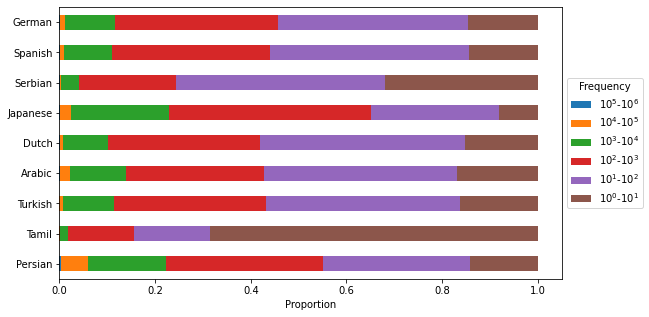

In [12]:
from numpy import log10


def freq_bins(l, r):
    return (
        # r.merge(pd.Series(total_counts[l]).rename('total'), left_on='ref', right_index=True, how='left')['total'].fillna(1)
        r[r["count"] != 0]
        .drop_duplicates()
        .sort_values("count")["count"]
        .apply(lambda x: f"$10^{int(log10(x))}$-$10^{int(log10(x)+1)}$")
        .value_counts()
    ) / len(r[r["count"] != 0].drop_duplicates())


fig, ax = plt.subplots(figsize=(9, 5))
pd.DataFrame(
    {
        code_lang.get(l, l).title(): freq_bins(l, ranks[l])
        for l in sorted(ranks, key=lambda l: len(ranks[l]))
    }
)[::-1].T.plot.barh(ax=ax, stacked=True)

ax.set_xlabel("Proportion")

import matplotlib.pyplot as plt

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Frequency")

plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.savefig(f"../paper/fig/mention-freq-bins.pgf", bbox_inches="tight")